In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
% matplotlib inline

# My Intuition

- Skipped Exploratory Analysis Feature Engineering Due to Preprocessing (Principal Components Analysis)
- Previewed The Class Imbalance Mentioned 
- Opted for A Support Vector Classifier With Class Weights & Undersampling

# The Data

**Source:** [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

# Kaggle Kernel Validating My Intuition & Introduced Alternatives

[Logistic Regressor, Supper Vector Classifier, Decision Tree, & Anomaly Detection](https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now)

# My Models

In [2]:
transactions = pd.read_csv('C:\\Users\\missn\\Documents\\Thinkful\\CSV Datasets\\Unit 3\\Supervised Learning Potpourri\\creditcard.csv')
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
transactions.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

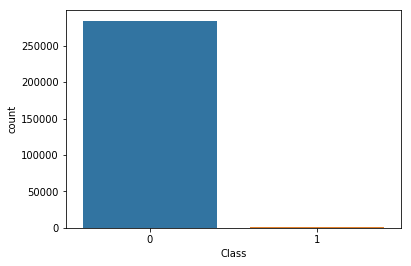

In [4]:
class_imbalance = sns.countplot(x='Class', data=transactions)

**This was my original downsampling implementation, which worked.**

In [5]:
fraudulent = transactions[transactions.Class == 1]
real_indices = transactions[transactions.Class == 0].index
real_downsample = np.random.choice(real_indices, 492, replace = False)
real = transactions.loc[real_downsample]
sample = pd.concat([fraudulent, real])

**In future, I'll use SKLearn's [resample utility](https://elitedatascience.com/imbalanced-classes) to correct class imbalance, but the implementation below didn't work as expected - I'm not sure why.**

In [6]:
# real = transactions[transactions.Class == 0]
# fraudulent = transactions[transactions.Class == 1]
# real_downsample = resample(real, replace=False, n_samples=492, random_state=0)
# sample = pd.concat([fraudulent, real])

In [7]:
sample.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

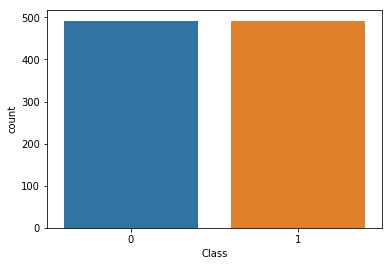

In [8]:
class_undersample = sns.countplot(x='Class', data=sample)

In [9]:
clf = SVC(class_weight='balanced', probability=True)

In [10]:
X_train = sample.drop(['Class'], 1)
Y_train = sample.Class

In [25]:
clf.fit(X_train,Y_train)
X_test = transactions.drop(['Class'], 1).sample(n=5000, replace=False)
Y_test = transactions.Class.sample(n=5000, replace=False)
scores = cross_val_score(clf, X_test, Y_test, cv=5)

In [19]:
print('Cross-Validation Scores: {}'.format(scores))
print('Averaged Cross-Validation Scores: {:.2%}.'.format(scores.mean()))

Cross-Validation Scores: [0.99502488 0.99502488 1.         1.         1.        ]
Averaged Cross-Validation Scores: 99.80%.


In [13]:
Y_pred = clf.predict(X_test)

**As suggested on Kaggle, given the test data's class imbalance, calculating Confusion Matrix accuracy didn't yield meaningful results.**

In [14]:
confusion_matrix = pd.crosstab(Y_test, Y_pred, margins = True)
tI_errors = confusion_matrix.loc[0.0, 1.0] / confusion_matrix.loc['All', 'All']
tII_errors = confusion_matrix.loc[1.0, 0.0] / confusion_matrix.loc['All', 'All']

In [15]:
confusion_matrix.head()

col_0,0,1,All
Class,,,
0,997,1,998
1,2,0,2
All,999,1,1000


In [16]:
print(('Type I Error Rate: {:.2%}.\n'
       'Type II Error Rate: {:.2%}.\n').format(tI_errors, tII_errors))

Type I Error Rate: 0.10%.
Type II Error Rate: 0.20%.



**I instead scored based on the Area Under the Receiver Operating Characteristic (AUROC) curve, which is defined as:**
- The expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative.
- The expected proportion of positives ranked before a uniformly drawn random negative.
- The expected true positive rate if the ranking is split just before a uniformly drawn random negative.
- The expected proportion of negatives ranked after a uniformly drawn random positive.
- The expected false positive rate if the ranking is split just after a uniformly drawn random positive.

In [27]:
prob_Y = clf.predict_proba(X_test)
prob_Y = [p[1] for p in prob_Y]
print('AUROC Score: {:.2%}.'.format(roc_auc_score(Y_test, prob_Y)))

AUROC Score: 46.10%.


## Feature Selection

**Although the features are intentionally masked for privacy, selection would be useful for model interpretation if I knew what they represented.**

In [26]:
#Pipeline Construction.
anova = SelectKBest(f_classif, k=10)
svm = SVC(kernel='rbf')
anova_svm = make_pipeline(anova, svm)

#Fitting & Cross-Validation.
anova_svm.fit(X_train,Y_train)
scores = cross_val_score(anova_svm, X_test, Y_test, cv=5)

#De-Masking Selected Features.
features = anova.get_support(indices=True)
feature_names = list(X_test.columns)
selected_features = []
for feature in features:
    selected_features.append(feature_names[feature])

#Printing Outcomes.
print('Cross-Validation Scores: {}\n'.format(scores))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores.mean()))
print('Selected Features: {}\n'.format(selected_features))

prob_Y = clf.predict_proba(X_test)
prob_Y = [p[1] for p in prob_Y]
print('AUROC Score: {:.2%}.'.format(roc_auc_score(Y_test, prob_Y)))

Cross-Validation Scores: [0.998002 0.998002 0.998    0.998999 0.998999]

Cross-Validation Score Averaged Across Folds: 99.84%.

Selected Features: ['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

AUROC Score: 46.10%.


# Investigation: Memory Issues

I found an [article](https://stats.stackexchange.com/questions/314329/can-support-vector-machine-be-used-in-large-data) that explains why given the observations in this dataset I was having memory issues with this model choice.